<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import random
from pycocotools import mask
TRAIN_DIR = '/content/drive/MyDrive/trainingset'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\trainingset'
TEST_DIR = '/content/drive/MyDrive/testset'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\testset'#
TRAIN_LABELS = '/content/drive/MyDrive/train.json'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\train.json'
TEST_LABELS =  '/content/drive/MyDrive/test.json'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\test.json'
IM_WIDTH = 700
IM_HEIGHT = 700

In [34]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [35]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = [] #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories.append(c['name'])

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = (torchvision.io.read_image(img_path)/255)
    return image,image#label
  def __len__(self):
    return len(os.listdir(self.img_dir))

In [36]:
#caricamento dei dataset di train e di test
trainset = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

In [37]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))

In [38]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels=3):
    super(AutoEncoder,self).__init__()
    self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding = 1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding = 1)
    self.pl = nn.MaxPool2d(2,stride = 2,return_indices=True)
    self.us = nn.MaxUnpool2d(2,stride=2)
    self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding = 1)
    self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding = 1)
    self.conv6 = nn.Conv2d(64, in_channels, kernel_size=3, padding = 1)

  def forward(self,x):
    #x.to('cuda')
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x, ind = self.pl(x)
    x = F.relu(self.us(x,ind))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    return x



In [ ]:
model = AutoEncoder()
#model.to('cuda')

In [ ]:
#questo metodo è preso dai notebook e va adattato al caso specifico (loss ecc...)
#costruisco un sottodataset di 200 immagini
#indexs = list(range(0,200))
#trains = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,indexs), batch_size=64, shuffle=True)
trains = torch.utils.data.DataLoader(trainset)
criterion = torch.nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(trains)
batch_size = 64

num_epochs = 1

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trains) for i in range(num_epochs + 1)]


def train(epoch,model,criterion,optimizer,reshape=False):
    for batch_idx, (images, labels) in enumerate(trains):
        # Move tensors to the configured device
        #if reshape:
         #   images = images.reshape(-1, 28*28)
        #images = images.to('cuda')
        #labels = labels.to('cuda')
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if random.random() < 0.1:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))
        if (batch_idx+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))

        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(trains)))

In [39]:
model = torch.load('/content/drive/MyDrive/autoencoder')
#train(num_epochs,model,criterion, optimizer, reshape=False)

In [ ]:
#torch.save(model,'autoencoder')

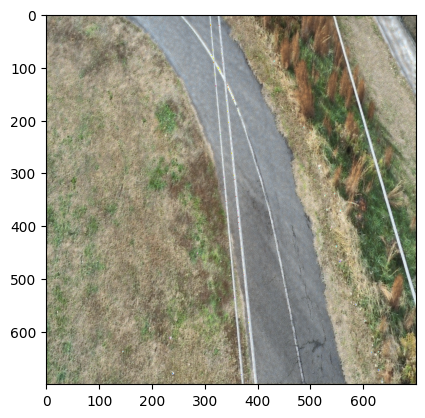

In [46]:
im = test[0][0]
r = model(im)
tra = torchvision.transforms.ToPILImage()
plt.imshow(tra(r))

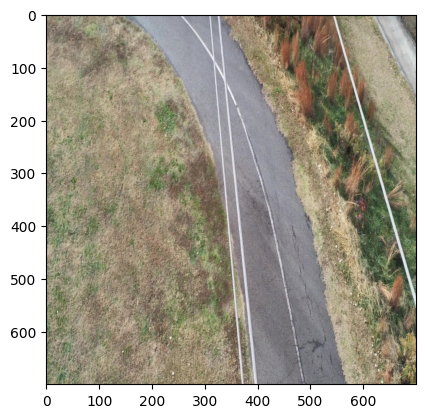

In [47]:

plt.imshow(tra(test[0][0]))

In [48]:
model.conv1.weight

Parameter containing:
tensor([[[[ 7.8255e-02, -1.8905e-01,  5.6035e-02],
          [-7.6405e-02, -1.5980e-01, -1.3783e-01],
          [ 3.6113e-02,  7.4156e-03, -1.6845e-01]],

         [[-6.5886e-02,  1.0054e-01, -5.6067e-02],
          [ 1.7610e-01, -8.0497e-02,  3.4056e-02],
          [-1.5175e-01, -1.0651e-01, -2.4098e-02]],

         [[-4.5369e-03, -1.5754e-01,  1.2913e-01],
          [-2.4493e-05, -1.0053e-01, -1.1493e-01],
          [-7.7301e-02,  7.3975e-02,  1.2787e-01]]],


        [[[-1.8553e-01,  8.3871e-02, -1.1646e-01],
          [ 1.4507e-01, -1.8943e-01, -1.0518e-01],
          [ 6.7800e-02,  2.2362e-02,  3.9171e-02]],

         [[-2.8985e-02,  1.7905e-01, -9.1752e-02],
          [-1.6895e-01, -3.7131e-02,  5.2548e-02],
          [ 1.4139e-01,  1.4266e-01, -6.4231e-02]],

         [[ 1.0874e-01, -2.0812e-03,  1.7811e-01],
          [ 1.6578e-01,  5.1414e-02, -1.1511e-01],
          [-1.4680e-01,  1.8620e-01,  7.8919e-02]]],


        [[[-2.3198e-02,  1.2972e-01,  1.2612